In [1]:
!pip install --upgrade tensorflow
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim
!pip install jupyterthemes
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import nltk
nltk.download('punkt')
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 439 kB 67.8 MB/s 
     |████████████████████████████████| 1.7 MB 55.3 MB/s 
     |████████████████████████████████| 6.0 MB 55.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Reading Dataset and doing some cleanings.
Merging titles and contents of each article

In [2]:
df=pd.read_csv('/content/FA-KES-Dataset.csv',encoding= 'latin1')
df.drop(columns = ['date'], inplace = True)
df.drop(columns = ['unit_id'], inplace = True)
df.drop(columns = ['location'], inplace = True)
df['original'] = df['article_title'] + ' ' + df['article_content']
df.head()

,article_title,article_content,source,labels,original
0,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,0,Syria attack symptoms consistent with nerve ag...
1,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,0,Homs governor says U.S. attack caused deaths b...
2,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,0,Death toll from Aleppo bomb attack at least 11...
3,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,0,Aleppo bomb blast kills six Syrian state TV We...
4,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,0,29 Syria Rebels Dead in Fighting for Key Alepp...


# Preproccessing Data
download and obtain stopwords

In [3]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Defining a function to Remove stopwprds

In [4]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token) 
    return result


In [5]:
df['clean'] = df['original'].apply(preprocess)
df.head()

,article_title,article_content,source,labels,original,clean
0,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,0,Syria attack symptoms consistent with nerve ag...,"[syria, attack, symptoms, consistent, nerve, a..."
1,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,0,Homs governor says U.S. attack caused deaths b...,"[homs, governor, says, attack, caused, deaths,..."
2,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,0,Death toll from Aleppo bomb attack at least 11...,"[death, toll, aleppo, bomb, attack, death, tol..."
3,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,0,Aleppo bomb blast kills six Syrian state TV We...,"[aleppo, bomb, blast, kills, syrian, state, al..."
4,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,0,29 Syria Rebels Dead in Fighting for Key Alepp...,"[syria, rebels, dead, fighting, aleppo, road, ..."


Number of total words in the dataset

In [6]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)
len(list_of_words)

141397

Number of total unique words

In [7]:
total_words = len(list(set(list_of_words)))
total_words

9012

Put words into a string

In [8]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df.head()

,article_title,article_content,source,labels,original,clean,clean_joined
0,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,0,Syria attack symptoms consistent with nerve ag...,"[syria, attack, symptoms, consistent, nerve, a...",syria attack symptoms consistent nerve agent s...
1,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,0,Homs governor says U.S. attack caused deaths b...,"[homs, governor, says, attack, caused, deaths,...",homs governor says attack caused deaths doesnt...
2,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,0,Death toll from Aleppo bomb attack at least 11...,"[death, toll, aleppo, bomb, attack, death, tol...",death toll aleppo bomb attack death toll alepp...
3,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,0,Aleppo bomb blast kills six Syrian state TV We...,"[aleppo, bomb, blast, kills, syrian, state, al...",aleppo bomb blast kills syrian state aleppo bo...
4,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,0,29 Syria Rebels Dead in Fighting for Key Alepp...,"[syria, rebels, dead, fighting, aleppo, road, ...",syria rebels dead fighting aleppo road syria r...


Plot how many samples are fake or valid

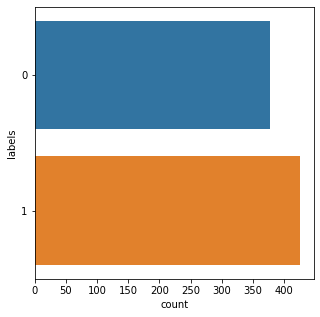

In [9]:
plt.figure(figsize = (5, 5))
sns.countplot(y = "labels", data = df)

max num of words in any document

In [10]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("max num of words in any document :", maxlen)

max num of words in any document : 799


Define some constants that are defined in the article.

In [11]:
MAX_SEQUENCE_LENGTH = 300  
EMBEDDING_DIM = 100
TEST_SPLIT = 0.2

train-test split with test size of 0.2

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.labels, test_size = TEST_SPLIT)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(643,)
(643,)
(161,)
(161,)


Define a tokenizer to tokenize the words. Then we should create sequences of tokenized words.

In [37]:
from nltk import word_tokenize
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print(len(train_sequences))
len(test_sequences)

643


161

In [33]:
print("document : \n",df.clean_joined[0],"\n Tokenized document : \n ",train_sequences[0])

document : 
 syria attack symptoms consistent nerve agent syria attack symptoms consistent nerve agent victims suspected chemical attack syria appeared symptoms consistent reaction nerve agent world health organization said wednesday cases appear additional signs consistent exposure chemicals category chemicals includes nerve agents said statement putting death toll united states said deaths caused sarin nerve dropped syrian aircraft russia said believes poison leaked rebel chemical weapons depot struck syrian bombs sarin organophosporus compound nerve agent chlorine mustard believed past syria russian defence ministry spokesman agent attack said rebels chemical weapons aleppo year said likely kind chemical attack sufferers apparent external injuries died rapid onset similar symptoms including acute respiratory distress said experts turkey giving guidance overwhelmed health workers idlib diagnosis treatment patients medicines atropine antidote types chemical exposure steroids symptomat

In [14]:
padded_train = pad_sequences(train_sequences,maxlen = MAX_SEQUENCE_LENGTH, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = MAX_SEQUENCE_LENGTH, truncating = 'post') 
print(padded_train.shape)
print(padded_test.shape)

(643, 300)
(161, 300)


In [35]:
print(padded_train[0])

[  64   91   42    4   29  111   64   91   42    4   29  111  143   93
 1787 1788 1789   54   29   64    3    6   26  355  241  480  282   42
    4   37    9   56   24   75   29   69  116   50   93    2   95  198
  213   37 2165   38  282  207    9  146    1   16    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

download glove.6B.100d.txt from kaggle. It will be used for word embeddings

In [15]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minaseyedi","key":"6510e8ac10106d94c0869743da7e2832"}'}

In [16]:
!rm -r ~/.kaggle #Remove Old Kaggle Directory
!mkdir ~/.kaggle #Create Kaggle Directory
!mv ./kaggle.json ~/.kaggle/ #Move kaggle.json in Directory
!chmod 600 ~/.kaggle/kaggle.json #Allocate the Required Permission for File.
!kaggle datasets list #Show List of Dataset

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                 5MB  2022-11-13 15:47:17          13539        382  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india    Credit Card Spending Habits in India           319KB  2022-12-14 07:30:37            904         37  1.0              
michals22/coffee-dataset                                        Coffee dataset                                  24KB  2022-12-15 20:02:12           3029         74  1.0              
thedevastator/unlock-pro

In [17]:
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt

 97% 128M/131M [00:05<00:00, 39.1MB/s]
100% 131M/131M [00:05<00:00, 25.8MB/s]


In [18]:
!unzip glove6b100dtxt.zip

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


Word embedding

In [19]:
import os
embeddings_index = {}
f = open(os.path.join('/content/glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Hybrid model

In [20]:
modell = Sequential()
modell.add(embedding_layer)
modell.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'))
modell.add(MaxPool1D(pool_size=2))
modell.add(LSTM(32))
modell.add(Dense(1, activation='sigmoid'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
modell.save('hybrid.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          811900    
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 148, 128)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 896,669
Trainable params: 896,669
Non-trainable params: 0
__________________________________________________

Trainig Hybrid model

In [21]:
y_train1 = np.asarray(y_train)
y_test1 = np.asarray(y_test)
hist1=modell.fit(padded_train, y_train1,validation_data=(padded_test,y_test1), epochs=10, batch_size=64)

Epoch 1/10
11/11 [==============================] - 14s 252ms/step - loss: 0.7521 - accuracy: 0.5179 - val_loss: 0.8054 - val_accuracy: 0.4534
Epoch 2/10
11/11 [==============================] - 2s 195ms/step - loss: 0.6816 - accuracy: 0.5428 - val_loss: 0.7248 - val_accuracy: 0.4534
Epoch 3/10
11/11 [==============================] - 2s 197ms/step - loss: 0.6774 - accuracy: 0.5272 - val_loss: 0.7509 - val_accuracy: 0.4534
Epoch 4/10
11/11 [==============================] - 2s 197ms/step - loss: 0.6658 - accuracy: 0.5692 - val_loss: 0.7444 - val_accuracy: 0.4907
Epoch 5/10
11/11 [==============================] - 2s 194ms/step - loss: 0.6608 - accuracy: 0.5288 - val_loss: 0.8154 - val_accuracy: 0.4720
Epoch 6/10
11/11 [==============================] - 2s 201ms/step - loss: 0.6507 - accuracy: 0.5879 - val_loss: 0.7469 - val_accuracy: 0.5528
Epoch 7/10
11/11 [==============================] - 2s 198ms/step - loss: 0.6363 - accuracy: 0.5910 - val_loss: 0.8332 - val_accuracy: 0.5342
Epoch

Plot loss and accuracy

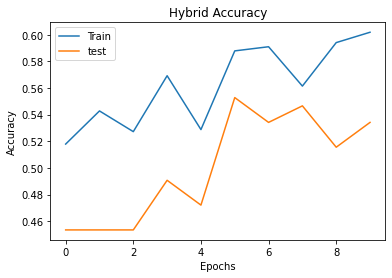

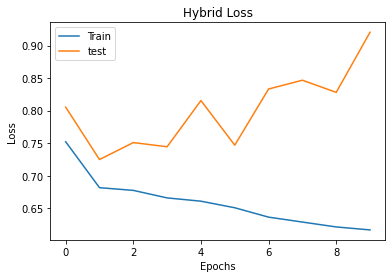

In [22]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Hybrid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Hybrid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'test'], loc='upper left')
plt.show()

Evaluate model using accuracy, precision, recall and f1-score metrics

In [23]:
pred = modell.predict(padded_test)
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(list(y_test), prediction)
precision=precision_score(list(y_test), prediction, average='weighted')
recall=recall_score(list(y_test), prediction,average='weighted')
f1=f1_score(list(y_test), prediction,average='weighted')
print("Model Accuracy : ", accuracy)
print("Model precision : ", precision)
print("Model recall : ", recall)
print("Model f1_score : ", f1)

6/6 [==============================] - 0s 8ms/step
Model Accuracy :  0.5341614906832298
Model precision :  0.5979098885931184
Model recall :  0.5341614906832298
Model f1_score :  0.4958316807488435


plot confusion matrix

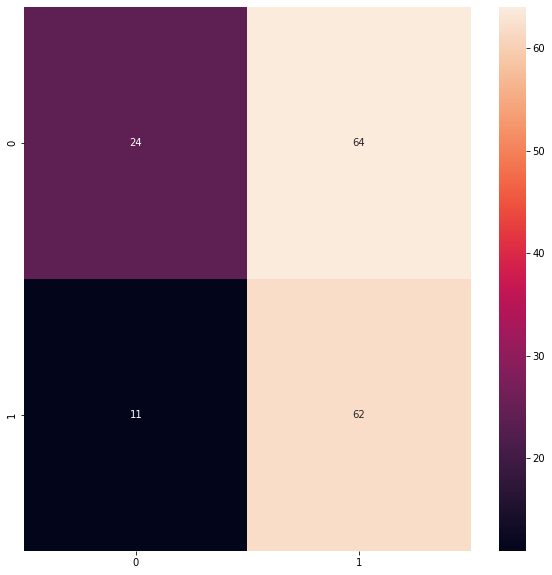

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test1), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

Define RNN model

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.save('lstm.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          811900    
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 828,957
Trainable params: 828,957
Non-trainable params: 0
_________________________________________________________________
None


Training LSTM model

In [26]:
y_train1 = np.asarray(y_train)
y_test1 = np.asarray(y_test)
hist2=model.fit(padded_train, y_train1,validation_data=(padded_test,y_test1), epochs=10, batch_size=64)

Epoch 1/10
11/11 [==============================] - 4s 228ms/step - loss: 0.6905 - accuracy: 0.5257 - val_loss: 0.7230 - val_accuracy: 0.4845
Epoch 2/10
11/11 [==============================] - 2s 196ms/step - loss: 0.6821 - accuracy: 0.5537 - val_loss: 0.7662 - val_accuracy: 0.4720
Epoch 3/10
11/11 [==============================] - 2s 189ms/step - loss: 0.6899 - accuracy: 0.4774 - val_loss: 0.7732 - val_accuracy: 0.4658
Epoch 4/10
11/11 [==============================] - 2s 194ms/step - loss: 0.6776 - accuracy: 0.5583 - val_loss: 0.7655 - val_accuracy: 0.4720
Epoch 5/10
11/11 [==============================] - 2s 163ms/step - loss: 0.6849 - accuracy: 0.5614 - val_loss: 0.7500 - val_accuracy: 0.4907
Epoch 6/10
11/11 [==============================] - 2s 154ms/step - loss: 0.6685 - accuracy: 0.5708 - val_loss: 0.7400 - val_accuracy: 0.5093
Epoch 7/10
11/11 [==============================] - 2s 186ms/step - loss: 0.6668 - accuracy: 0.5614 - val_loss: 0.7404 - val_accuracy: 0.5093
Epoch 

Plot loss and accuracy

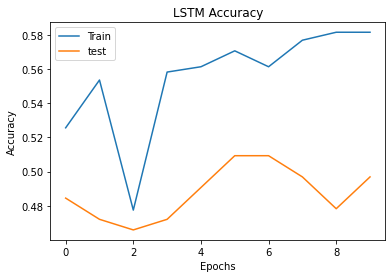

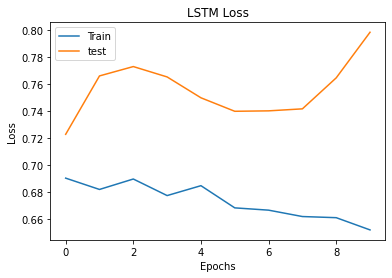

In [27]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'test'], loc='upper left')
plt.show()

Evaluate model using accuracy, precision, recall and f1-score metrics

In [28]:
pred = model.predict(padded_test)
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
        
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(list(y_test), prediction)
precision=precision_score(list(y_test), prediction, average='weighted')
recall=recall_score(list(y_test), prediction,average='weighted')
f1=f1_score(list(y_test), prediction,average='weighted')
print("Model Accuracy : ", accuracy)
print("Model precision : ", precision)
print("Model recall : ", recall)
print("Model f1_score : ", f1)

6/6 [==============================] - 0s 8ms/step
Model Accuracy :  0.4968944099378882
Model precision :  0.5700333063282024
Model recall :  0.4968944099378882
Model f1_score :  0.4270812863435983


plot confusion matrix

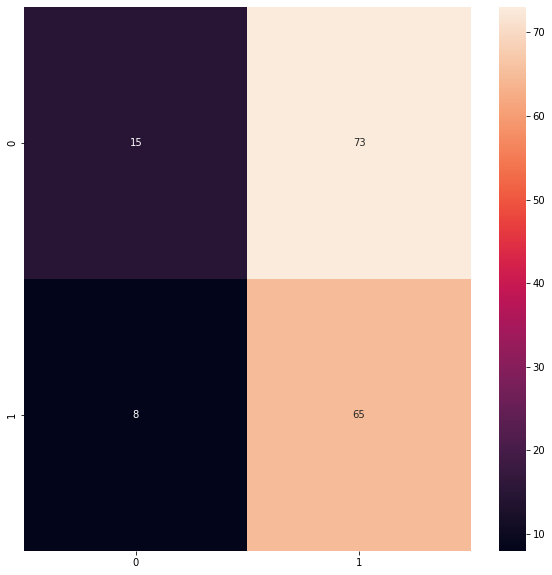

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test1), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)